# Time Series - Infosys Stock Price Predictions

## Introduction
This is an attempt to predict Stock prices based on Stock prices of previous days. The stock market refers to the collection of markets and exchanges where regular activities of buying, selling, and issuance of shares of publicly-held companies take place.

This is a time series analysis and we will see different ways to predict the stock prices. The various models to be used are:
1. Avearage
2. Weighted Average
3. Moving Average
4. Weighted Moving Average
5. Linear Regression
6. Weighted Linear Regression
7. Lasso Regression
8. Moving Window Neural Network

In [1]:
# import necessary libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

In [2]:
# original datasets:

original_data = pd.read_csv("infy_stock.csv")
original_data.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2015-01-01,INFY,EQ,1972.55,1968.95,1982.00,1956.9,1971.00,1974.40,1971.34,500691,9.870306e+13,14908,258080,0.5154
1,2015-01-02,INFY,EQ,1974.40,1972.00,2019.05,1972.0,2017.95,2013.20,2003.25,1694580,3.394669e+14,54166,1249104,0.7371
2,2015-01-05,INFY,EQ,2013.20,2009.90,2030.00,1977.5,1996.00,1995.90,2004.59,2484256,4.979911e+14,82694,1830962,0.7370
3,2015-01-06,INFY,EQ,1995.90,1980.00,1985.00,1934.1,1965.10,1954.20,1954.82,2416829,4.724458e+14,108209,1772070,0.7332
4,2015-01-07,INFY,EQ,1954.20,1965.00,1974.75,1950.0,1966.05,1963.55,1962.59,1812479,3.557162e+14,62463,1317720,0.7270


### The Data:
The data we use for prediction would be for closing price of infosys in NSE (National Stock Exchange) for the business days in 2015. So we will import only the date column and closing price column.

In [3]:
df = pd.read_csv("infy_stock.csv", usecols=['Date', 'Close'], parse_dates=['Date'], index_col='Date')
df.head()

,Close
Date,
2015-01-01,1974.40
2015-01-02,2013.20
2015-01-05,1995.90
2015-01-06,1954.20
2015-01-07,1963.55


In [4]:
df.shape

# we have data on working days only and so there are 248 data with start date as 01-01-2015 and end date as 31-12-2015.

(248, 1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 2015-01-01 to 2015-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   248 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB


In [6]:
# checking min & max value of data.
print("Min:", df.index.min())
print("Max:", df.index.max())

Min: 2015-01-01 00:00:00
Max: 2015-12-31 00:00:00


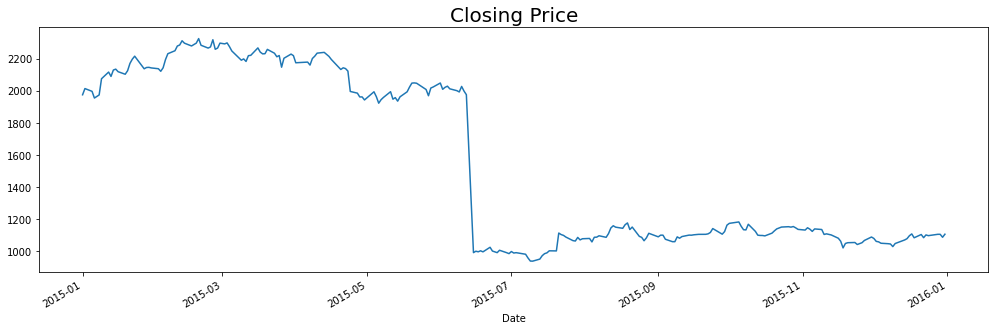

In [7]:
plt.figure(figsize=(17,5))
df.Close.plot()
plt.title("Closing Price", fontsize=20)
plt.show()

## Adjustment for split-up
There is a huge drop on 15/06/2015, this was the <span style="color:blue">fifth split </span> in Infosys Share Price. If we take this whole data, prediction might not be as expected as there is a split in between!

We have to either drop the data or adjust the values before split. Since the split is 2 for 1, we can normalize the data prior to split by dividing then by 2. (Old share are half that of today's share).

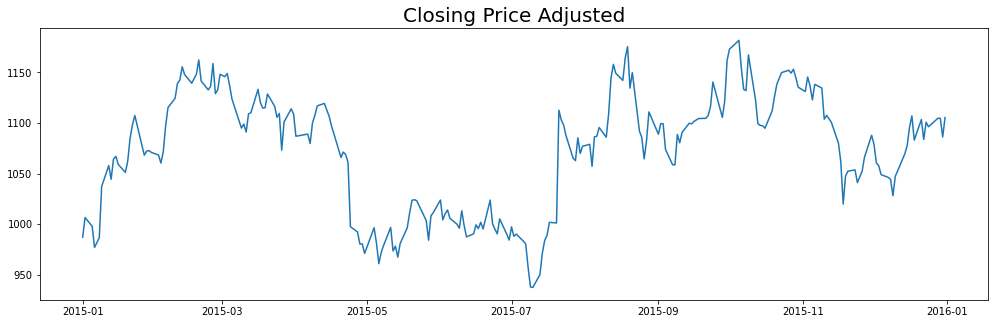

In [8]:
# The Split
plt.figure(figsize=(17,5))
stock_price = pd.concat([df.Close[:'2015-06-12']/2, df.Close['2015-06-15':]]) # adjustment
plt.plot(stock_price)
plt.title('Closing Price Adjusted', fontsize=20)
plt.show()

And now we have an adjusted time series of Infosys stock prices.

Lets now Predict the Stock price based on various methods.

   * We will predict the values on last 68 days in the series.
   * We will use Mean squared error as a metrics to calculate the error in our prediction.
   * We will compare the results of various methods at the end.

In [9]:
#helper function to plot the stock prediction
prev_values = stock_price.iloc[:180] # training
y_test = stock_price.iloc[180:]   # test

def plot_pred(pred, title):
    plt.figure(figsize=(17,5))
    plt.plot(prev_values, label='Train')
    plt.plot(y_test, label='Actual')
    plt.plot(pred, label='Predicted')
    plt.ylabel("Stock Prices")
    plt.title(title, fontsize=20)
    plt.legend()
    plt.show()

## 1. Average
This is the simplest model. We will get as average of the previous values and predict it as the forecast.

In [10]:
# Average of previous values
y_av = pd.Series(np.repeat(prev_values.mean(), 68), index=y_test.index)
mse(y_av, y_test)

3173.6356476000856

In [11]:
np.sqrt(mse(y_av, y_test))

56.33503037720035

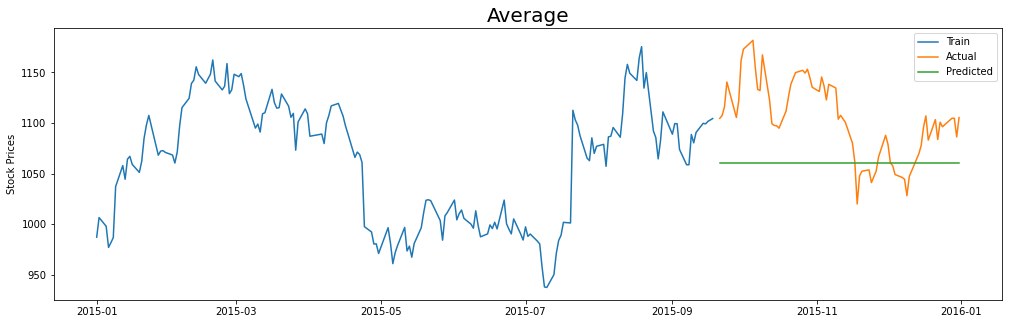

In [12]:
plot_pred(y_av, "Average")
plt.show()

## 2. Weighted Mean
We shall give more weightage to the data which are close to the last day in training data, while calculating the mean. The last day in the training set will give a weightage of 1(=180/180) and the first day will get a weightage of 1/180.

In [13]:
weight = np.array(range(0,180))/180
weighted_train_data = np.multiply(prev_values, weight)

# weighted average is the sum of this weighted train data by the sum of the weight

weighted_average = sum(weighted_train_data)/sum(weight)
y_wa = pd.Series(np.repeat(weighted_average, 68), index=y_test.index)

print("MSE:", mse(y_wa, y_test))
print("MSE:", np.sqrt(mse(y_wa, y_test)))

MSE: 3496.475652551586
MSE: 59.1310041564625


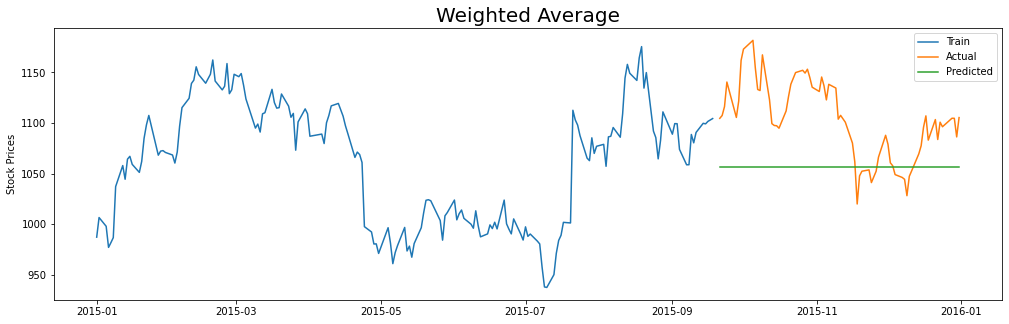

In [14]:
plot_pred(y_wa, "Weighted Average")
plt.show()

For the other methods we will predict the value of stock price on a day based on the values of stock prices of 80 days prior to it. So in our series we will not consider the first eight days (since there previous eighty days is not in the series).

We have to test the last 68 values. This would be based on the last 80 days stock prices of each day in the test data.

Since we have neglected first 80 and last 68 in our test set, the train dataset will be between 80 and 180 (100 days).

In [15]:
y_train = stock_price[80:180]
y_test = stock_price[180:]
print("y_train:", y_train.shape, "\ny_test:", y_test.shape)

y_train: (100,) 
y_test: (68,)


There are 100 days in training and 68 days in testing set. We will construct the festures, that is the last 68 days stock for each date in the y_train and y_test. This would be our target variable.

In [16]:
X_train = pd.DataFrame([list(stock_price[i:i+80]) for i in range(100)],
                      columns= range(80,0,-1), index=y_train.index)
X_test = pd.DataFrame([list(stock_price[i:i+80]) for i in range(100, 168)],
                      columns= range(80,0,-1), index=y_test.index)

X_train

,80,79,78,77,76,75,74,73,72,71,...,10,9,8,7,6,5,4,3,2,1
Date,,,,,,,,,,,,,,,,,,,,,
2015-04-30,987.200,1006.600,997.950,977.100,981.775,986.725,1037.225,1057.975,1044.450,1064.325,...,1097.325,1089.625,1066.075,1071.300,1068.850,1061.000,997.600,992.325,980.450,980.575
2015-05-04,1006.600,997.950,977.100,981.775,986.725,1037.225,1057.975,1044.450,1064.325,1067.125,...,1089.625,1066.075,1071.300,1068.850,1061.000,997.600,992.325,980.450,980.575,971.125
2015-05-05,997.950,977.100,981.775,986.725,1037.225,1057.975,1044.450,1064.325,1067.125,1059.150,...,1066.075,1071.300,1068.850,1061.000,997.600,992.325,980.450,980.575,971.125,996.550
2015-05-06,977.100,981.775,986.725,1037.225,1057.975,1044.450,1064.325,1067.125,1059.150,1051.250,...,1071.300,1068.850,1061.000,997.600,992.325,980.450,980.575,971.125,996.550,981.375
2015-05-07,981.775,986.725,1037.225,1057.975,1044.450,1064.325,1067.125,1059.150,1051.250,1062.100,...,1068.850,1061.000,997.600,992.325,980.450,980.575,971.125,996.550,981.375,961.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-11,1023.225,1008.400,1003.650,984.250,1008.300,1011.575,1023.900,1004.325,1010.450,1014.025,...,1111.050,1094.400,1089.000,1099.450,1099.350,1073.950,1058.750,1058.800,1088.700,1080.450
2015-09-14,1008.400,1003.650,984.250,1008.300,1011.575,1023.900,1004.325,1010.450,1014.025,1005.825,...,1094.400,1089.000,1099.450,1099.350,1073.950,1058.750,1058.800,1088.700,1080.450,1090.750
2015-09-15,1003.650,984.250,1008.300,1011.575,1023.900,1004.325,1010.450,1014.025,1005.825,1000.025,...,1089.000,1099.450,1099.350,1073.950,1058.750,1058.800,1088.700,1080.450,1090.750,1099.750


X train is now a collection of 100 dates as index and a collection of stock prices of previous 80 days as features.

Similarlily, X_test is now a collection of 68 dates as index and a collection of stock prices of previous 80 days as features.

NOTE: Here 76 working days from '2015-05-04', the stock had a price of 986.725 and 77 working days from '2015-05-05', the stock has the same value. You can see the similarity of values along the diagonal. This is because consecutitive data will be similar to the previous except it drops the last value, shifts and has a new value.

We will use these values for stock price predictions in the other four methods.

## 3. Moving Average
We have to predict the 68 values in data set and for each values we will get the average of previous 80 days.
   
This will be a simple mean of each column in the y_test.

In [17]:
y_ma = X_test.mean(axis=1)
print(" MSE:", mse(y_ma, y_test))
print("RMSE:",np.sqrt(mse(y_ma, y_test)))

 MSE: 2901.424183296478
RMSE: 53.86486965821488


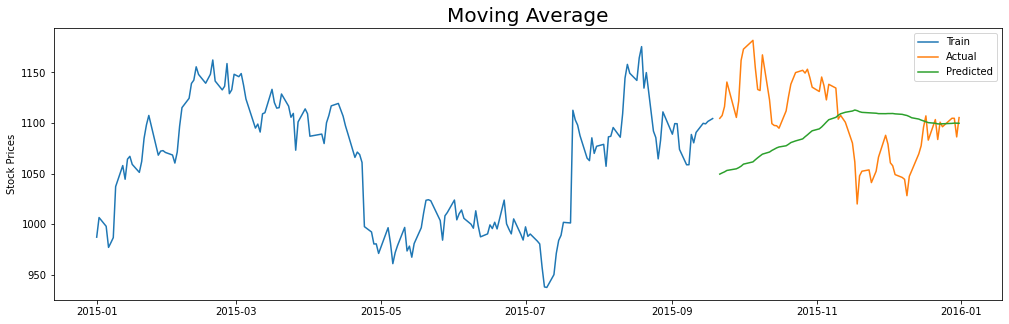

In [18]:
plot_pred(y_ma, "Moving Average")

## 4. Weighted Moving Average
We will obtain the stock price on the test date by calculating the weighted mean of past 80 days. The last of the 80 day will have a weightage of 1(=80/80) and the first will have a weightage of 1/80.

In [19]:
weight = np.array(range(1,81))/80
# weighted moving average
y_wma = X_test@weight/sum(weight)
print(" MSE:", mse(y_wma, y_test))
print("RMSE:", np.sqrt(mse(y_wma, y_test)))

 MSE: 1769.433203930821
RMSE: 42.06463127059146


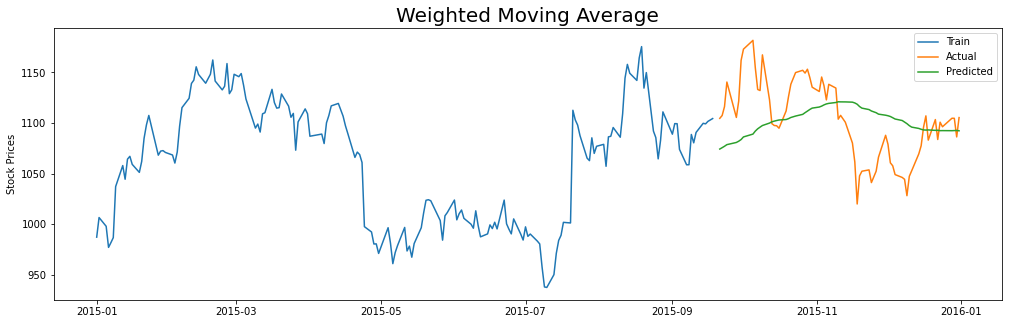

In [20]:
plot_pred(y_wma, "Weighted Moving Average")

## 5. Linear Regression
In this method, we will perform a linear regression on our dataset. The values will be predicted as a linear combination of the previous 80 days values.

In [21]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr.fit(X_train, y_train)  # training the models
y_lr = lr.predict(X_test)
y_lr = pd.Series(y_lr, index=y_test.index)

print(" MSE:", mse(y_test, y_lr))
print("RMSE:", np.sqrt(mse(y_test, y_lr)))

 MSE: 1754.1645412925625
RMSE: 41.88274753753104


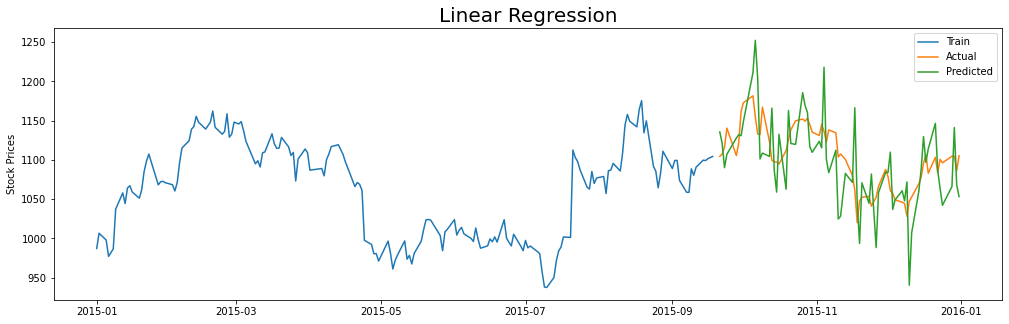

In [22]:
plot_pred(y_lr, "Linear Regression")

## 6. Weighted Linear Regression
We provide weighted to our input data rather than the features.

In [23]:
weight = np.array(range(1,101))/100

from sklearn.linear_model import LinearRegression
wlr = LinearRegression()

wlr.fit(X_train, y_train, weight)  # training the models
y_wlr = wlr.predict(X_test)
y_wlr = pd.Series(y_wlr, index=y_test.index)

print(" MSE:", mse(y_test, y_wlr))
print("RMSE:", np.sqrt(mse(y_test, y_wlr)))

 MSE: 2054.3614078787446
RMSE: 45.325063793432705


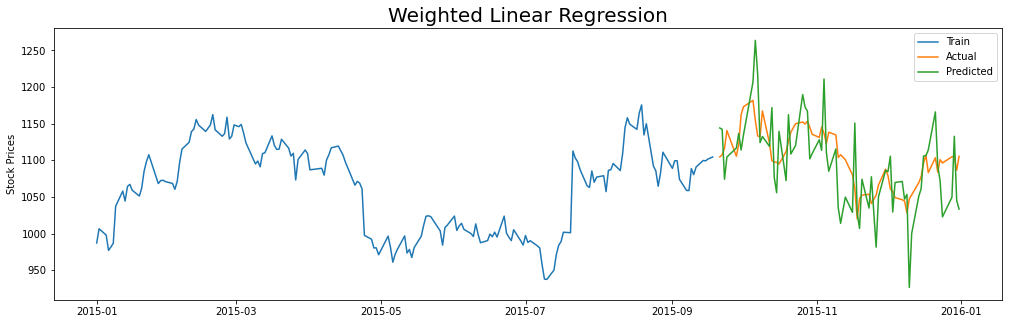

In [24]:
plot_pred(y_wlr, "Weighted Linear Regression")

## 7. Lasso Regression
Linear regression with L1 regualtions.

In [25]:
from sklearn.linear_model import Lasso
lasso = Lasso()

las = lasso.fit(X_train, y_train)
y_las = las.predict(X_test)
y_las = pd.Series(y_las, index=y_test.index)

print(" MSE:", mse(y_test, y_las))
print("RMSE:", np.sqrt(mse(y_test, y_las)))

 MSE: 1467.3338646133786
RMSE: 38.305794138920795


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.020e+02, tolerance: 3.391e+01
  model = cd_fast.enet_coordinate_descent(


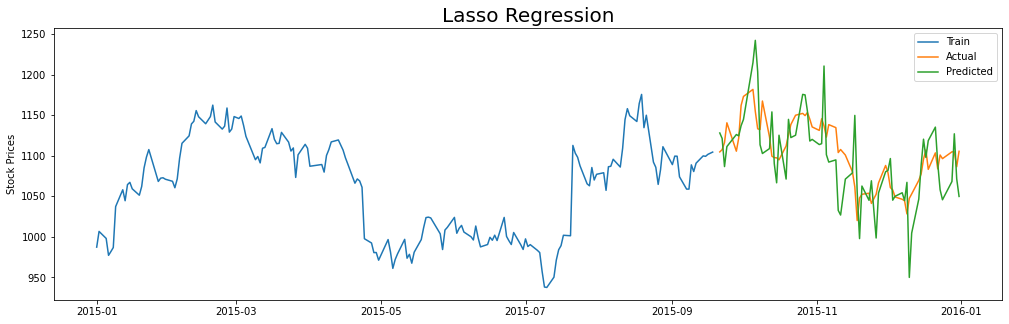

In [26]:
plot_pred(y_las, "Lasso Regression")

## 8. Moving Window Neural Network
We construct a simple feed forward network taking 80 features as our input.

In [27]:
from keras.models import Sequential
from keras.layers import Dense

# moving average neural network
ma_nn = Sequential([Dense(64, input_shape=(80,), activation='relu'),
                   Dense(32, activation='linear'), Dense(1)])

ma_nn.compile(loss='mse', optimizer='rmsprop', metrics=['mae','mse'])

history = ma_nn.fit(X_train, y_train, epochs=250, batch_size=32, validation_split=0.25)

2024-01-03 06:39:39.835707: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-03 06:39:39.875836: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


VOC-NOTICE: GPU memory for this assignment is capped at 1024MiB


2024-01-03 06:39:41.812402: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/250
3/3 [==============================] - 1s 80ms/step - loss: 755490.1250 - mae: 825.1856 - mse: 755490.1250 - val_loss: 3872.0312 - val_mae: 50.2578 - val_mse: 3872.0312
Epoch 2/250
3/3 [==============================] - 0s 10ms/step - loss: 19333.9375 - mae: 111.0158 - mse: 19333.9375 - val_loss: 45329.6406 - val_mae: 204.2789 - val_mse: 45329.6406
Epoch 3/250
3/3 [==============================] - 0s 10ms/step - loss: 9933.1670 - mae: 76.3690 - mse: 9933.1670 - val_loss: 6155.5718 - val_mae: 65.9540 - val_mse: 6155.5718
Epoch 4/250
3/3 [==============================] - 0s 10ms/step - loss: 20811.0234 - mae: 121.8267 - mse: 20811.0234 - val_loss: 48063.3203 - val_mae: 210.9165 - val_mse: 48063.3203
Epoch 5/250
3/3 [==============================] - 0s 9ms/step - loss: 12008.7021 - mae: 89.7113 - mse: 12008.7021 - val_loss: 53281.1211 - val_mae: 222.9886 - val_mse: 53281.1211
Epoch 6/250
3/3 [==============================] - 0s 10ms/step - loss: 35986.2539 - mae: 158.6639 

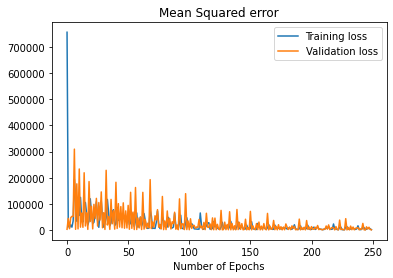

In [28]:
plt.plot(history.history['mse'],label='Training loss')
plt.plot(history.history['val_mse'], label='Validation loss')
plt.title("Mean Squared error")
plt.xlabel("Number of Epochs")
plt.legend()
plt.show()

In [29]:
loss_nn,mae_nn,mse_nn = ma_nn.evaluate(X_test,y_test)
print("\nloss:",loss_nn,"\nmae:",mae_nn,"\nmse:",mse_nn)

3/3 [==============================] - 0s 2ms/step - loss: 3224.0562 - mae: 43.2840 - mse: 3224.0562

loss: 3224.05615234375 
mae: 43.284000396728516 
mse: 3224.05615234375
